# Loading images
### Section 4 (Figure 13 and Table 1)

In [2]:
import numpy as np
from qiskit import IBMQ, execute, transpile, QuantumCircuit
from qiskit.tools.monitor import job_monitor

from qclib.state_preparation import CvoqramInitialize
from qclib.gates.initialize_sparse import InitializeSparse
from qclib.util import double_sparse

In [3]:
# Image load.
n_qubits = 5
matrix_dim = int(2**(n_qubits/2))

np.random.seed(7)
sparse = double_sparse(n_qubits, 3, 0.1)

vec = []
for index in range(2**n_qubits):
    b_str = f'{index:0{n_qubits}b}'
    if b_str in sparse:
        vec.append(1)
    else:
        vec.append(complex(0.0))

input_state = vec/np.linalg.norm(vec)

In [4]:
# Plots examples of the states that represent the images.

_dpi = 300
def plot_digits(vectors, labels, text=''):
    import matplotlib.pyplot as plt
    ncols = len(vectors)
    _, axes = plt.subplots(nrows=1, ncols=ncols, dpi=_dpi)
    for ax, vector, label in zip(axes, vectors, labels):
        ax.set_axis_off()
        image = vector[:int(matrix_dim**2)].reshape(matrix_dim, matrix_dim)
        ax.imshow(image, cmap=plt.cm.gray, interpolation='none')
        ax.set_title(label)
        
    plt.savefig(f'save/smile{text}.pdf')
    plt.show()

In [6]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

shots      = 8192
backend  = provider.get_backend('ibm_oslo')

In [7]:
def measurement(job):
    counts = job.result().get_counts()
    v = sum(counts.values())
    
    counts2 = {}
    for m in range(2**n_qubits):
        pattern = '{:0{}b}'.format(m, n_qubits)
        if pattern in counts:
            counts2[pattern] = counts[pattern]
        else:
            counts2[pattern] = 0.0

    prob = { key : value/v for (key, value) in counts2.items() }

    return np.array([val for key, val in prob.items()])    

In [8]:
jobs = {}
circuits = {}
t_circuits = {}

In [9]:
initializers = {
    'cvo qiskit':(CvoqramInitialize, {'with_aux':False, 'mcg_method':'qiskit'}),
    'cvo barenco':(CvoqramInitialize, {'with_aux':False, 'mcg_method':'barenco'}),
    'cvo linear':(CvoqramInitialize, {'with_aux':False, 'mcg_method':'linear'}),
}

In [10]:
# Build the quantum circuits
for label, (initializer, opt_params) in initializers.items():
    print(label, ' ', end='')
    
    if issubclass(initializer, InitializeSparse):
        data = {f'{b:0{n_qubits}b}':d for b, d in enumerate(input_state) if d > 10**-15}
    else:
        data = input_state

    gate = initializer(data, opt_params=opt_params).definition
    circuit = QuantumCircuit(gate.num_qubits, n_qubits)
    circuit.append(gate, circuit.qubits)
    
    print(gate.num_qubits, ' ', end='')

    if label[:3] == 'cvo':
        circuit.measure(list(range(1, n_qubits+1)), list(range(n_qubits)))
    else:
        circuit.measure(list(range(n_qubits)), list(range(n_qubits)))

    circuits[label] = circuit

cvo qiskit  6  cvo barenco  6  cvo linear  6  

In [11]:
# Table 1 CNOTs and depth (MAEs for Table 1 in the last cell)

# Transpile the quantum circuits and count the number of CNOTs
for label, (initializer, opt_params) in initializers.items():
    print(label, ' ', end='')
    circuit = circuits[label]

    t_circuit = transpile(
        circuit,
        backend=backend,
        optimization_level=3
    )
    ops = t_circuit.count_ops()
    print(ops.get('cx', 0), t_circuit.depth(), ' ', end='')

    t_circuits[label] = t_circuit

cvo qiskit  149 320  cvo barenco  82 190  cvo linear  39 113  

In [12]:
for label, (initializer, opt_params) in initializers.items():
    jobs[label] = []

In [53]:
import time
from qiskit.providers.jobstatus import JobStatus

def count_running_jobs(jobs):
    count = 0
    for _, jobs_list in jobs.items():
        count += sum([job.status() in (
            JobStatus.RUNNING, JobStatus.INITIALIZING, JobStatus.QUEUED, JobStatus.VALIDATING
        ) for job in jobs_list])
    return count

reps = 1

for label, (initializer, opt_params) in initializers.items():
    print(label, ' ', end='')

    for rep in range(reps):
        print('.', end='')
        while count_running_jobs(jobs) >= 20: # maximum number (20) of concurrent jobs
            time.sleep(5) # Sleep for 5 seconds

        job = execute(
            circuits[label],
            backend,
            shots=shots,
            optimization_level=3,
        )
        jobs[label].append(job)


cvo qiskit  .cvo barenco  .cvo linear  .

In [ ]:
_images = []
_labels = []
_images.append(np.abs(input_state)**2)
_labels.append('ideal')
for label, (initializer, opt_params) in initializers.items():
    print(label,' ', end='')
    print(len(jobs[label]), end='')
    results = []
    for job in jobs[label]:
        print('.', end='')
        job_monitor(job, quiet=True)
        try:
            results.append(measurement(job))
        except Exception as e:
            print('erro:', e)

    _images.append(np.mean(results, axis=0))
    _labels.append(label)

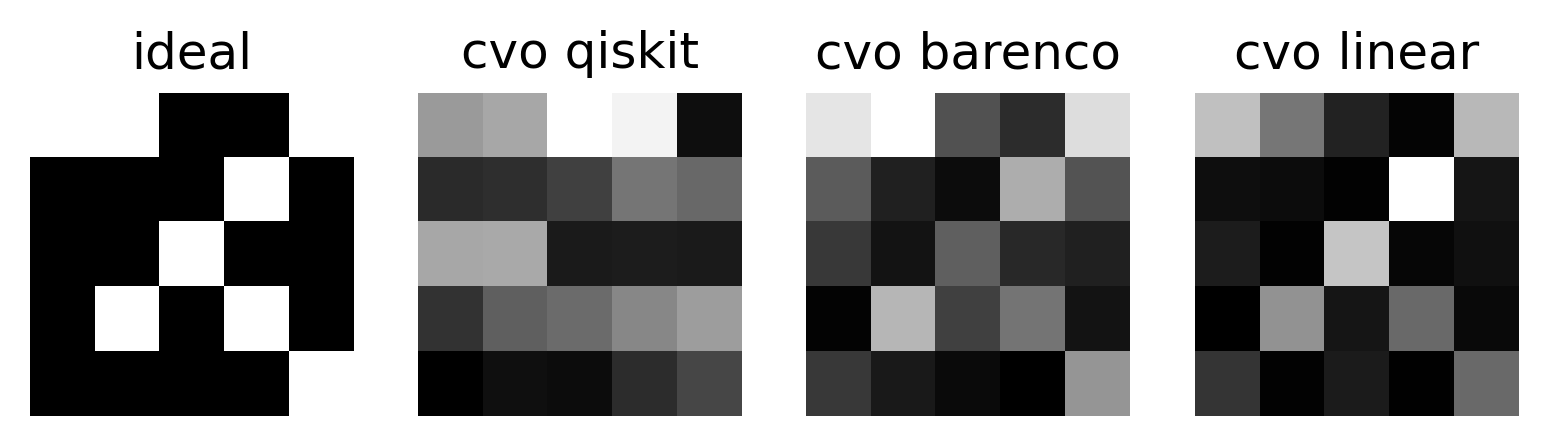

In [82]:
plot_digits(_images, _labels, '_'+backend.name())

In [83]:
# Table 1 MAEs

def mae(state, ideal):
    """
    Mean Absolute Error
    """
    return np.sum(np.abs(state-ideal))/len(ideal)

for image in _images:
    print(mae(_images[0], image))

0.0
0.04541015624999999
0.03137207031249999
0.016540527343749993
